Intro:
************************************************************************************************************** 
In this project I will be performing Exploratory Data Analysis and implement Unsupervised and Supervised models to inspect data provided by countries across the globe. The data I will be exploring contains many different statistics and metrics and I will use different methods to visiualize the data and machine learning models to demonstarte what I've learned so far.

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pytest import approx
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")

Importing the data and defining our data frame.

In [114]:
df = pd.read_csv('Country-data.csv')
print(df.shape)
print(df.columns)
df.isnull().sum() #No nulls

(167, 10)
Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')


country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [115]:
#df.head(15)
df.info()
#f.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


I will visiualize my data to help determine the next approach in EDA. I am looking for features that may have a high correlation or see if any features are unneccesary. I will also see if dimensionality reduction is necessary.   

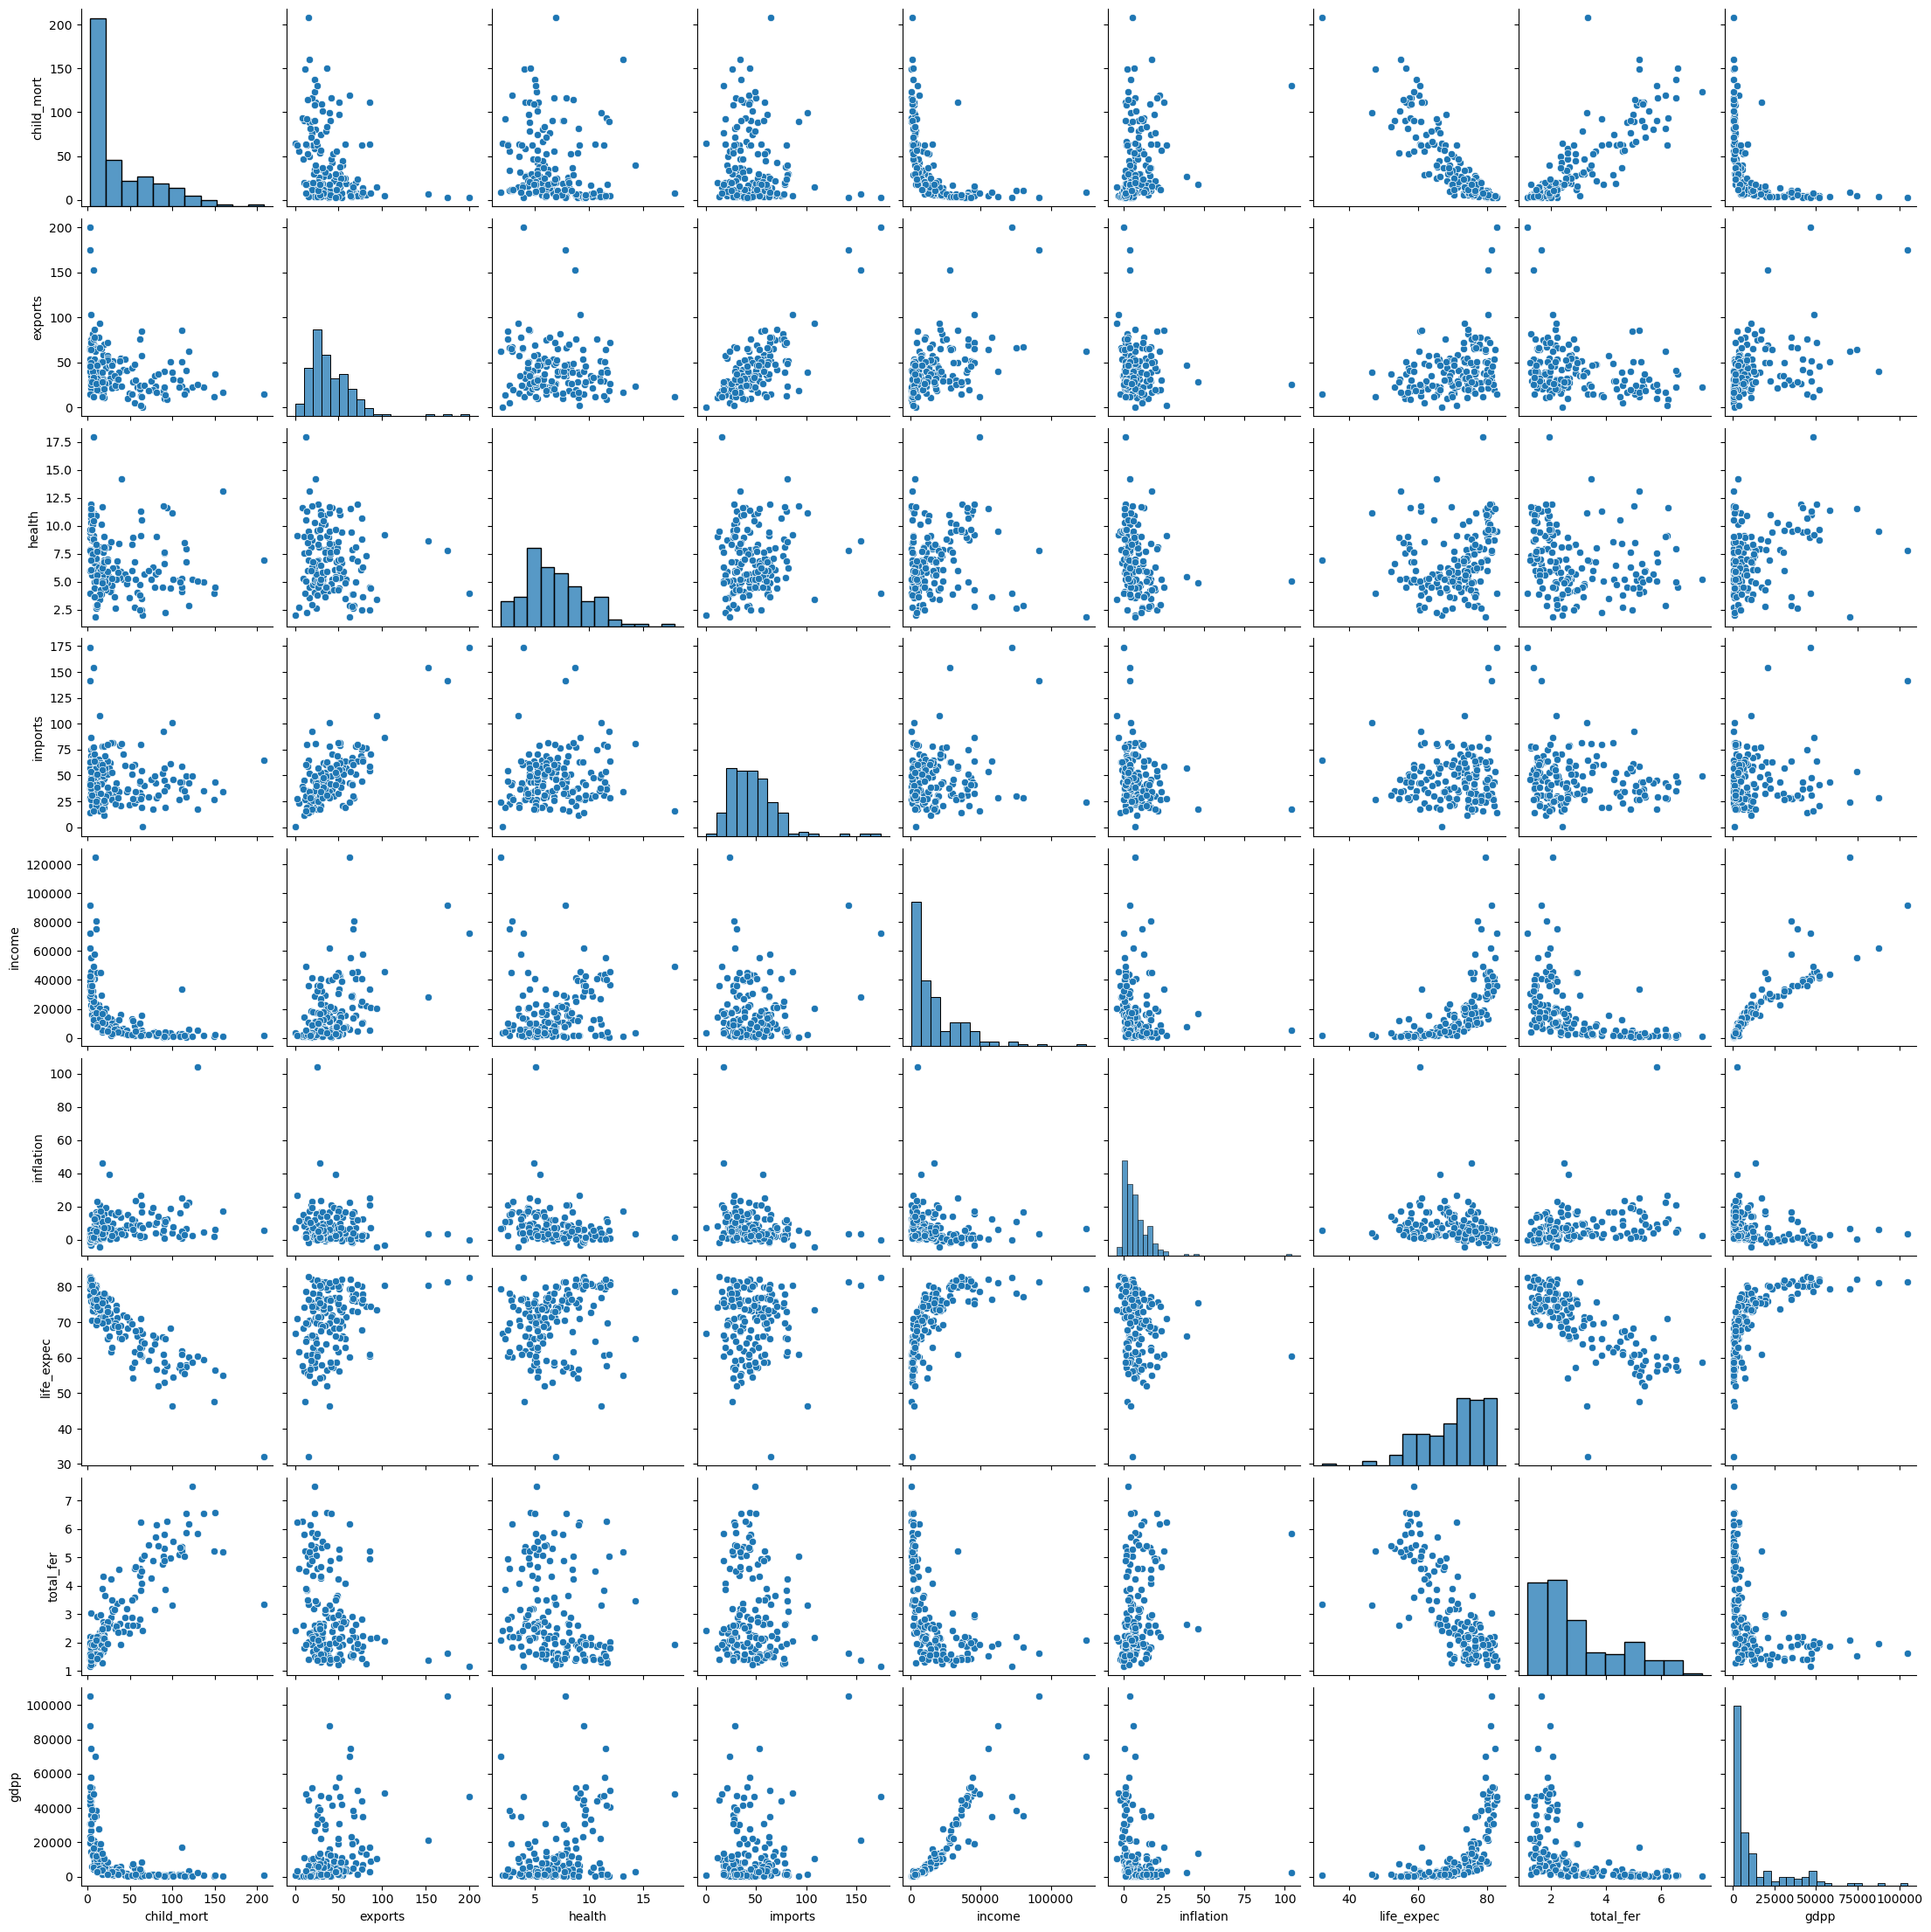

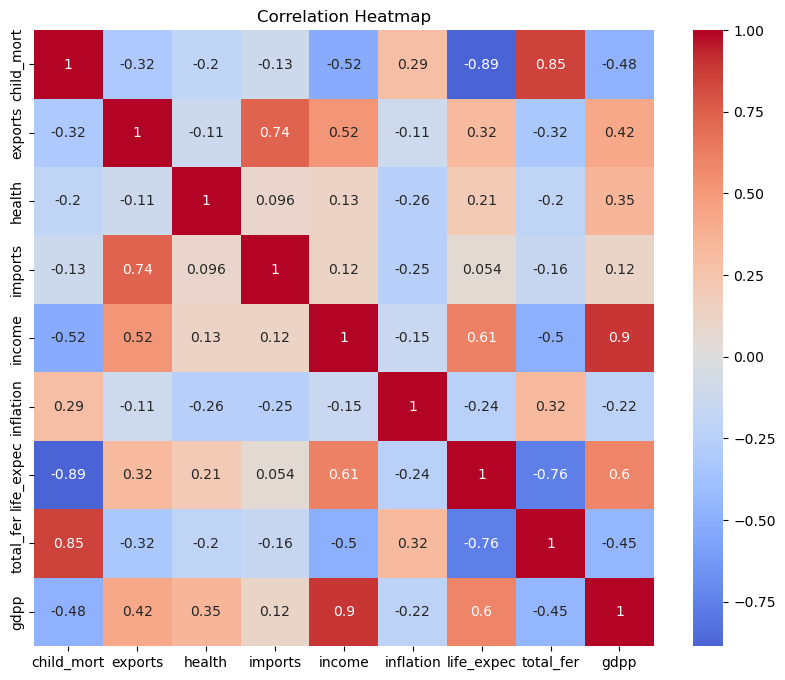

In [116]:
#visualize pair plots for numerical variables
sns.pairplot(df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']])
plt.show()

#correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

A couple features stand out from the heatmap that I will explore further. I will apply dimension reduction to some highly correlated features in an attempt to capture the most important patterns and data to reduce redundacy.

In the pairplot, we can choose the plots that appear clustered to be candidates for dimension reduction to capture any patterns.

In [117]:
#child_mort and total_fer, gdpp and income, life expect and child_mort, total_fer and health.
#High correlations might suggest redundant information that could be captured using dimensionality reduction.

#selecting to observe relationship between total fertility and health.

# Isolate the 'total_fer' and 'health' columns
selected_columns1 = ['total_fer', 'health']
clustering_data = df[selected_columns1]

I will utilize the unsupervised model Kmeans to identify clustering patterns from what I observed in the scatterplot. Unsuperised methods don't rely on labels and instead use distance metrics to determine relationships between data points. I will then split my data into test and training sets to demonstrate any disparities in performance between supervised and unsupervised models.

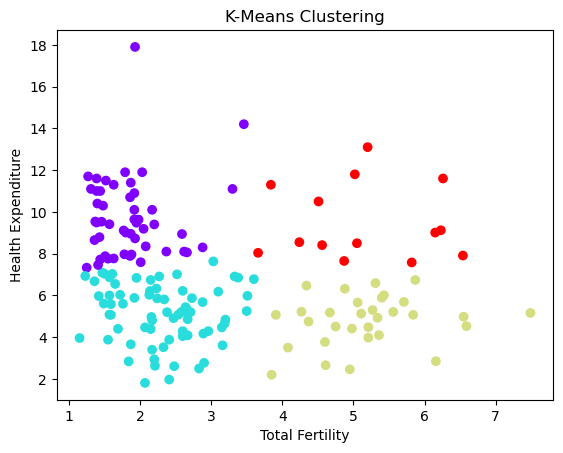

In [118]:
#standardizing the data
scaler = StandardScaler()
#.fit_tansform() learns our data by getting mean, std, etc.
scaled_data = scaler.fit_transform(clustering_data) 

#choosing num of clusters
num_clusters = 4

#creating Kmeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

#fit the model
kmeans.fit(scaled_data)

#getting cluster assignments for each data point
cluster_labels = kmeans.labels_
#print(cluster_labels)

# Add cluster labels to the original DataFrame
df['cluster'] = cluster_labels

# Visualize the clusters
plt.scatter(df['total_fer'], df['health'], c=df['cluster'], cmap='rainbow')
plt.xlabel('Total Fertility')
plt.ylabel('Health Expenditure')
plt.title('K-Means Clustering')
plt.show()

From this Kmeans visualization we can see some patterns based off of the color of the data points.

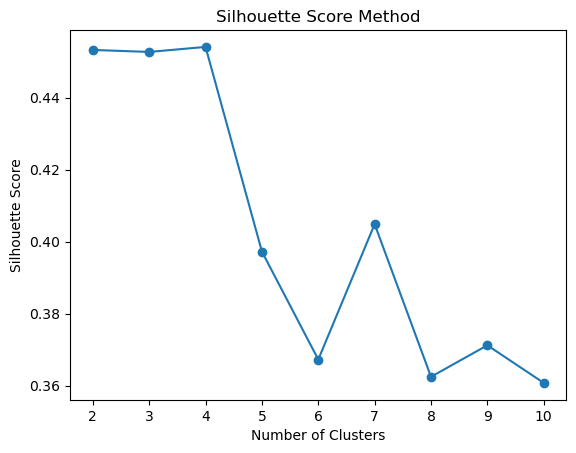

In [119]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

Tuning Hyperparameters: I decided to plot the Silhoutte Score which measures how similar an object is to its own cluster compared to other clusters. The range of the value (y-axis) go from -1 to 1 where the higher values are the better scores. As we can see, the optimal amount of clusters is 4 then it trails off the more clusters you add despite 7 being the anomaly. 

******************************************************************************************************
Supervised Learning: Below I will implement a supervised learning model and create a target feature.
First, I will categorize the data from each country and represent them as developed, developing, and underdeveloped from their GDP per capita. Then I will use the new data frame to create a target feature and implement a supervised learning model. 

In [120]:
#loading data again
df2 = pd.read_csv('Country-data.csv')
#print(df2['gdpp'].max())
#defining the GDP per capita. Will use values
 
developed_range = 20000
developing_range = 5000 

#creating new column for hypothetical target feature
df2['gdp_category'] = 'Underdeveloped'
df2.loc[df2['gdpp'] > developed_range, 'gdp_category'] = 'Developed'
df2.loc[(df2['gdpp'] > developed_range) & (df2['gdpp'] <= developed_range), 'gdp_category'] = 'Developing'
df2.loc[df2['gdpp'] < developing_range, 'gdp_category'] = 'Underdeveloped'

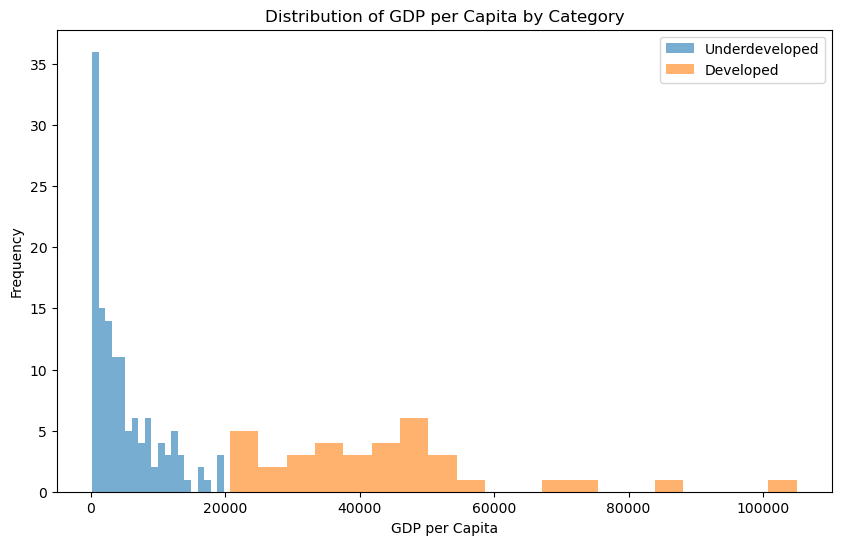

In [121]:
# Print a sample of the updated DataFrame
#print(df2[['country', 'gdpp', 'gdp_category']].sample(10))

#creating a histogram
plt.figure(figsize=(10, 6))
for category in df2['gdp_category'].unique():
    category_data = df2[df2['gdp_category'] == category]
    plt.hist(category_data['gdpp'], bins=20, alpha=0.6, label=category)

plt.xlabel('GDP per Capita')
plt.ylabel('Frequency')
plt.title('Distribution of GDP per Capita by Category')
plt.legend()
plt.show()

This quick visualization is a histogram of developed and underdeveloped countries. We can see there is a large disparity between countries with a large and small GDP per capita.

In [122]:
#Select the features and target variable for the supervised model
supervised_selected_features = ['total_fer', 'health', 'income']  
X = df2[supervised_selected_features]
y = df2['gdp_category']

#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training the Support Vector Classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train,y_train)

#predict using trained model
y_pred = svm_model.predict(X_test)

#Evaluate the model using accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


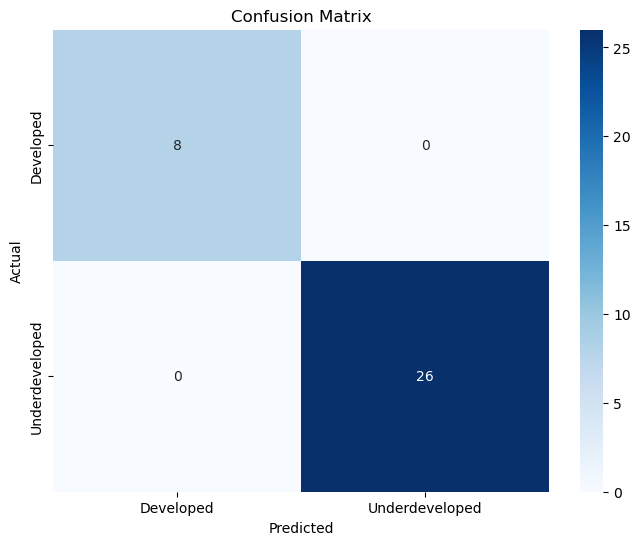

In [123]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

As we can see from out confusion matrix, the supervised model correctly predicted all the labels with a 100% accuracy showing how effective this model is.

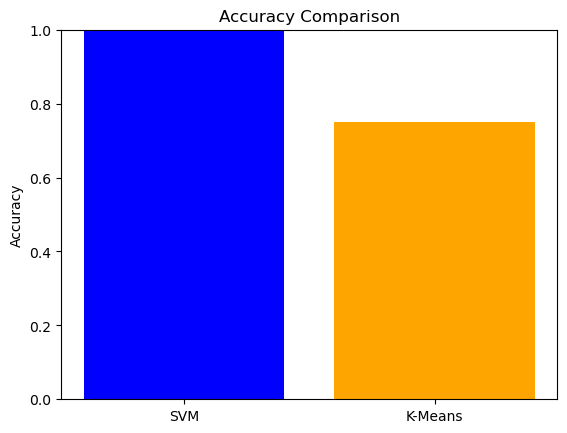

In [124]:
kmeans_accuracy = 0.75  
model_names = ['SVM', 'K-Means']
accuracies = [accuracy, kmeans_accuracy]

plt.bar(model_names, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

Conclusion:
***************************************************************************************************************
With K-Means clustering, the concept of "accuracy" is not directly applicable as it is in supervised classification tasks. This is because K-Means clustering doesn't predict labels that correspond to target variables since it's an unsupervised method. The main objective is to group data points based on their similarity.

However when implementing the supervised learning method Support Vector Machine, we manipulated the data to create a target variable and used the columns identifying the countries to classify them into certain groups. We then split the data into testting and training sets in order to train the model and found the performance to accurately label every feature. I believe having a larger and more complex data set would have degraded the performance of this model since it would be harder to identify patterns especially visually. 